### [The Hidden Values of Building Realistic Synthetic Data](https://medium.com/data-science-collective/the-hidden-values-of-building-realistic-synthetic-data-da2bf2914ac3)

> *Three reasons why I believe there is a lot of value in generating synthetic data, including a hands-on exercise in Python*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score, mean_absolute_error
from tqdm import tqdm
import string
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Random Seed and Number of Samples
np.random.seed(42)
n_samples = 1000

## Order IDs
order_ids = np.arange(1, n_samples + 1)

## Order Dates
date_range = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")
order_dates = np.random.choice(date_range, size=n_samples)

In [2]:
competitors = ["BuildCo", "MegaMaterials", "StoneWorks", "RoadSupplies", "QuickMix"]

competitor_probabilities = [0.2, 0.5, 0.15, 0.05, 0.1]
nearest_competitor_name = np.random.choice(
    competitors,
    p = competitor_probabilities,
    size=n_samples)

nearest_competitor_distance = np.random.exponential(scale=10, size=n_samples).round(2)

In [3]:
customer_types = ["Residential", "Commercial", "Industrial", "Government"]

customer_type_probabilities = [0.6, 0.2, 0.1, 0.1]
customer_type = np.random.choice(
    customer_types,
    p = customer_type_probabilities,
    size=n_samples)

In [4]:
customer_type_volume_multiplier_ranges = {
    "Residential": (0.5, 1.5),
    "Commercial": (1.2, 2.5),
    "Industrial": (2.2, 4.5),
    "Government": (3.5, 6.5)
}

concrete_volume = np.random.lognormal(mean=2.5, sigma=0.5, size=n_samples).round(2)
granite_volume = np.random.lognormal(mean=2.0, sigma=0.6, size=n_samples).round(2)
stone_volume = np.random.lognormal(mean=1.8, sigma=0.7, size=n_samples).round(2)
asphault_volume = np.random.lognormal(mean=2.2, sigma=0.5, size=n_samples).round(2)

customer_type_volume_multiplier = np.zeros(n_samples)
for i, c_type in enumerate(customer_type):
    low, high = customer_type_volume_multiplier_ranges[c_type]
    customer_type_volume_multiplier[i] = np.random.uniform(low, high)

concrete_volume = (concrete_volume * customer_type_volume_multiplier).round(2)
granite_volume = (granite_volume * customer_type_volume_multiplier).round(2)
stone_volume = (stone_volume * customer_type_volume_multiplier).round(2)
asphault_volume = (asphault_volume * customer_type_volume_multiplier).round(2)

In [5]:
concrete_unit_price = np.random.uniform(90, 110, n_samples)
granite_unit_price = np.random.uniform(60, 80, n_samples)
stone_unit_price = np.random.uniform(40, 60, n_samples)
asphault_unit_price = np.random.uniform(70, 90, n_samples)

order_months = pd.to_datetime(order_dates).month
seasonal_months = [4, 5, 6, 7]
seasonal_mask = np.isin(order_months, seasonal_months)
seasonal_uplift = np.random.uniform(1.05, 1.2, seasonal_mask.sum())

concrete_unit_price[seasonal_mask] *= seasonal_uplift
granite_unit_price[seasonal_mask] *= seasonal_uplift
stone_unit_price[seasonal_mask] *= seasonal_uplift
asphault_unit_price[seasonal_mask] *= seasonal_uplift

labor_cost = np.random.uniform(200, 1000, n_samples) + (concrete_volume*0.01) + (granite_volume*0.1) + (stone_volume*0.07) + (asphault_volume*0.05)
material_cost = (
    concrete_volume * concrete_unit_price +
    granite_volume * granite_unit_price +
    stone_volume * stone_unit_price +
    asphault_volume * asphault_unit_price
)
total_cost = material_cost + labor_cost

In [6]:
base_markup = np.random.uniform(1.05, 1.35, n_samples)
initial_order_price = total_cost * base_markup

competitor_price_multiplier_ranges = {
    "BuildCo": (1.01, 1.05),
    "MegaMaterials": (1.0, 1.2),
    "StoneWorks": (1.3,1.5),
    "RoadSupplies": (1.2, 1.25),
    "QuickMix": (1.1,2.2)
}
competitor_order_price_multiplier = np.zeros(n_samples)
for i, comp_type in enumerate(nearest_competitor_name):
    low, high = competitor_price_multiplier_ranges[comp_type]
    competitor_order_price_multiplier[i] = np.random.uniform(low, high)

competitor_adjusted_order_price = initial_order_price * competitor_order_price_multiplier

competitor_distance_coef = np.random.uniform(0.01, 0.2, n_samples)
competitor_markup_adj = nearest_competitor_distance * competitor_distance_coef
competitor_distance_adjusted_order_price = competitor_adjusted_order_price * (1 + competitor_markup_adj)

floor_price = total_cost * 1.05
final_order_price = np.maximum(competitor_distance_adjusted_order_price, floor_price).round(2)

In [7]:
df = pd.DataFrame({
    "order_id": order_ids,
    "order_date": order_dates,
    "customer_type": customer_type,
    "nearest_competitor_distance": nearest_competitor_distance,
    "nearest_competitor_name": nearest_competitor_name,
    "concrete_volume": concrete_volume,
    "granite_volume": granite_volume,
    "stone_volume": stone_volume,
    "asphault_volume": asphault_volume,
    "total_cost": total_cost.round(2),
    "order_price": final_order_price
})

df.head()

,order_id,order_date,customer_type,nearest_competitor_distance,nearest_competitor_name,concrete_volume,granite_volume,stone_volume,asphault_volume,total_cost,order_price
0,1,2024-05-10,Residential,0.60,MegaMaterials,12.79,16.97,4.76,7.03,4729.93,7027.39
1,2,2024-12-31,Commercial,4.07,MegaMaterials,31.53,13.49,19.86,12.31,7116.60,10106.88
2,3,2024-11-10,Residential,15.37,MegaMaterials,10.54,6.10,18.63,13.00,4165.16,16984.43
3,4,2022-05-02,Commercial,12.30,StoneWorks,17.83,5.08,8.54,12.68,4876.80,11950.35
4,5,2023-04-12,Commercial,15.54,MegaMaterials,27.57,7.53,2.68,15.93,6456.21,29834.22


In [8]:
#### Extract Month
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.month

In [9]:
df.dtypes

,0
order_id,int64
order_date,datetime64[ns]
customer_type,object
nearest_competitor_distance,float64
nearest_competitor_name,object
concrete_volume,float64
granite_volume,float64
stone_volume,float64
asphault_volume,float64
total_cost,float64


In [10]:
df.describe()

,order_id,order_date,nearest_competitor_distance,concrete_volume,granite_volume,stone_volume,asphault_volume,total_cost,order_price,order_month
count,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,2023-07-18 22:48:00.000000256,9.914580,24.917000,15.236880,13.650950,18.202590,6525.116790,18970.036940,6.384000
min,1.000000,2022-01-01 00:00:00,0.000000,1.550000,0.700000,0.710000,1.710000,1263.130000,2198.980000,1.000000
25%,250.750000,2022-09-26 18:00:00,2.997500,9.887500,5.597500,4.230000,7.210000,3367.250000,7245.085000,3.000000
50%,500.500000,2023-08-16 00:00:00,6.805000,16.280000,10.285000,8.035000,11.990000,4760.890000,12093.170000,6.000000
75%,750.250000,2024-04-15 12:00:00,14.057500,29.717500,18.150000,16.535000,21.732500,7501.987500,22903.820000,10.000000
max,1000.000000,2024-12-31 00:00:00,64.050000,240.540000,234.350000,182.110000,170.550000,37436.010000,240000.560000,12.000000
std,288.819436,NaN,9.780021,26.429019,16.193432,16.446689,18.517104,5082.230625,20785.044601,3.487794


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   order_id                     1000 non-null   int64         
 1   order_date                   1000 non-null   datetime64[ns]
 2   customer_type                1000 non-null   object        
 3   nearest_competitor_distance  1000 non-null   float64       
 4   nearest_competitor_name      1000 non-null   object        
 5   concrete_volume              1000 non-null   float64       
 6   granite_volume               1000 non-null   float64       
 7   stone_volume                 1000 non-null   float64       
 8   asphault_volume              1000 non-null   float64       
 9   total_cost                   1000 non-null   float64       
 10  order_price                  1000 non-null   float64       
 11  order_month                  1000 non-null  

<Axes: >

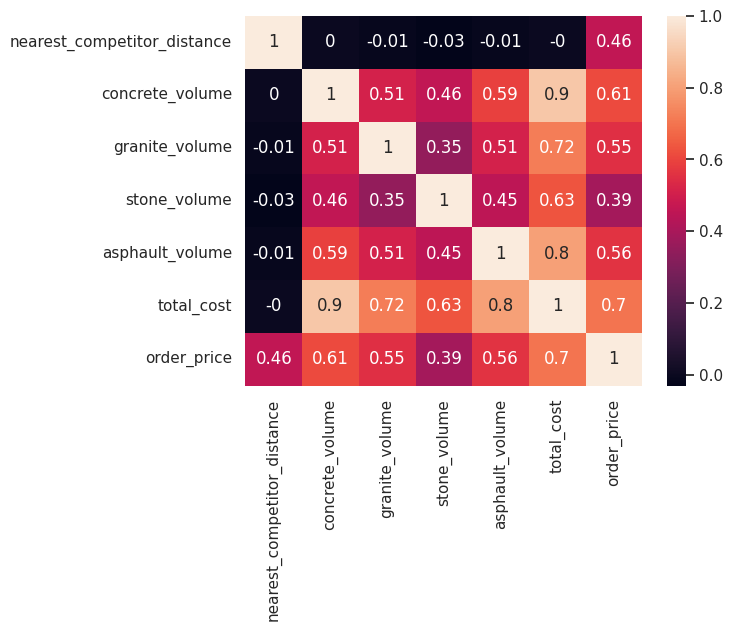

In [12]:
num_cols = list(df.select_dtypes(include='number').columns)
num_cols.remove('order_id')
num_cols.remove('order_month')
#num_cols.remove('margin_percentage')

corr_df = round(df[num_cols].corr(),2)
sns.heatmap(corr_df, annot=True)

In [13]:
df.order_month = df.order_month.astype('object')

cat_columns = list(df.select_dtypes(include='object').columns)

for c in cat_columns:
    print("---------------")
    print(df[c].value_counts() / df[c].value_counts().sum())

---------------
customer_type
Residential    0.597
Commercial     0.203
Industrial     0.111
Government     0.089
Name: count, dtype: float64
---------------
nearest_competitor_name
MegaMaterials    0.496
BuildCo          0.201
StoneWorks       0.150
QuickMix         0.098
RoadSupplies     0.055
Name: count, dtype: float64
---------------
order_month
5     0.095
4     0.094
1     0.090
3     0.088
10    0.088
12    0.087
2     0.081
8     0.080
11    0.077
7     0.076
6     0.074
9     0.070
Name: count, dtype: float64


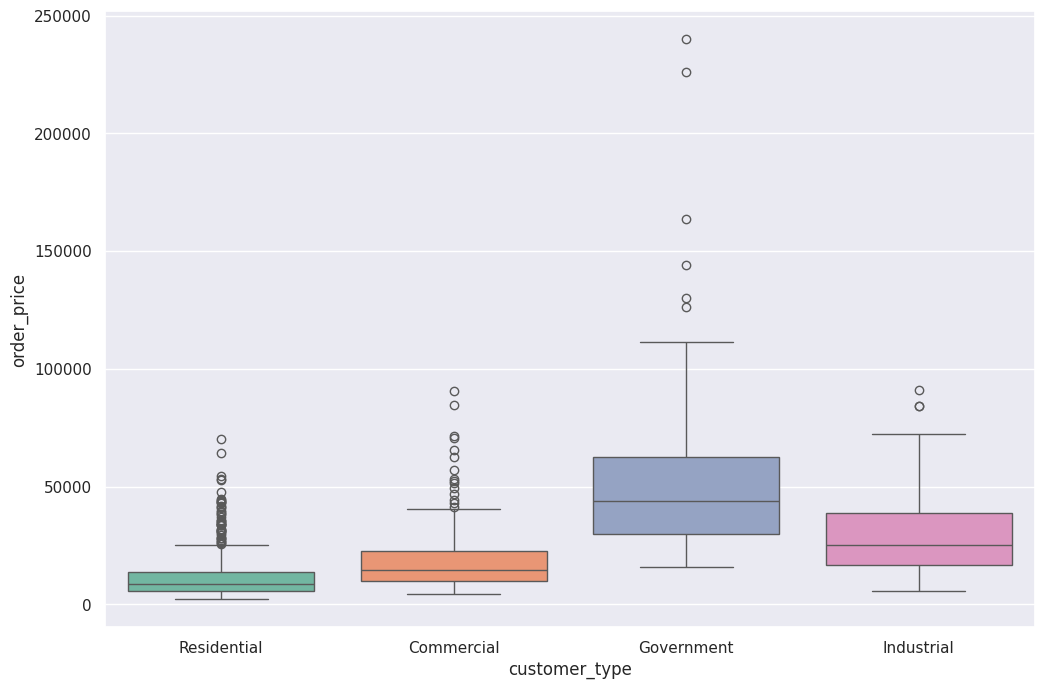

In [14]:
plt.figure(
    figsize=(12,8)
)

sns.boxplot(
  x='customer_type',
  y='order_price',
  data=df,
  hue = 'customer_type',
  palette='Set2')

plt.show()

In [15]:
!pip install -U --no-cache-dir pingouin

In [16]:
import pingouin as pg
gh_results = pg.pairwise_gameshowell(
    dv='order_price',
    between='customer_type',
    data=df
)

gh_results

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Commercial,Government,19067.259655,54329.098652,-35261.838997,4444.772919,-7.933327,97.439363,2.177547e-11,-1.382580
1,Commercial,Industrial,19067.259655,30110.627477,-11043.367822,1945.902937,-5.675189,189.062818,3.070848e-07,-0.711415
2,Commercial,Residential,19067.259655,11594.327973,7472.931682,1067.553499,7.000054,264.260962,1.265216e-10,0.691616
3,Government,Industrial,54329.098652,30110.627477,24218.471174,4642.960303,5.216170,114.132676,4.892287e-06,0.797830
4,Government,Residential,54329.098652,11594.327973,42734.770678,4348.587427,9.827276,89.382873,0.000000e+00,2.501200
5,Industrial,Residential,30110.627477,11594.327973,18516.299504,1714.859921,10.797558,121.812843,7.105427e-15,1.672056


In [17]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

df_sorted = df.sort_values('order_date').reset_index(drop=True)

split_idx = int(0.8 * len(df_sorted))
train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

X_train = train_df.drop(columns=['order_id', 'order_date', 'order_price'])
y_train = train_df['order_price']

X_test = test_df.drop(columns=['order_id', 'order_date', 'order_price'])
y_test = test_df['order_price']

In [18]:
def convert_object_to_category(df):
    df = df.copy()
    object_cols = df.select_dtypes(include='object').columns
    df[object_cols] = df[object_cols].astype('category')
    return df

X_train = convert_object_to_category(X_train)
X_test = convert_object_to_category(X_test)

In [19]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True,
    verbosity=1,
    eval_metric='rmse',
    random_state=42
)

param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train,
    y_train)

best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Adjusted R²: {adj_r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': np.float64(1.0), 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.23555555555555557), 'gamma': 0.5, 'colsample_bytree': np.float64(0.6)}
Adjusted R²: 0.6243
MAE: 6168.1134
MAPE: 30.40%


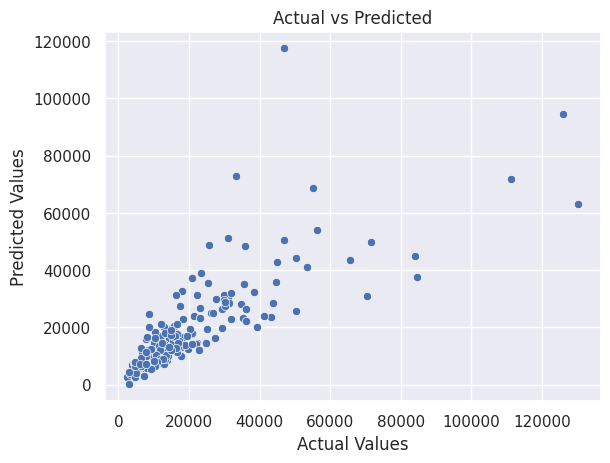

In [20]:
# Create a DataFrame for easier plotting
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create the scatter plot
sns.scatterplot(data=df, x='Actual', y='Predicted')

# Add plot labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')

# Show the plot
plt.show()